In [2]:
import os, time, itertools, tqdm
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from scipy import sparse
from scipy.sparse.linalg import inv
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.quantum_info import DensityMatrix
from operators.triangle_plaquette_hamiltonian import TrianglePlaquetteHamiltonian
from operators.pauli_hamiltonian import PauliHamiltonian
from quantum_circuit.trotterization import trotter_electric, trotter_coupling, trotter_plaquette
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
from qiskit.providers.jobstatus import JobStatus
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from utils.matrix_operations import *
from utils.operations import *

In [2]:
# Initialize Simulator|
backend = Aer.get_backend('statevector_simulator')

In [3]:
sig = []
sig.append(np.eye(2))
sig.append(np.array([[0, 1], [1, 0]]))
sig.append(np.array([[0, -1j], [1j, 0]]))
sig.append(np.array([[1, 0], [0, -1]]))

In [4]:
def change_basis_measurement(circ, i, trg):
    if i == 1:
        circ.h(trg)
    elif i == 2:
        circ.rx(np.pi/2, trg)
        
def change_basis_input(circ, i, trg):
    if i == 0:
        circ.h(trg)
    elif i == 1:
        circ.ry(-np.pi/2, trg)
    elif i == 2:
        circ.rx(np.pi/2, trg)
    elif i == 3:
        circ.rx(-np.pi/2, trg)
    elif i == 5:
        circ.x(trg)

In [18]:
# Load IBMQ account
IBMQ.load_account() # Load account from disk
print(IBMQ.providers())    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q-ornl', project='brookhaven')
print(provider.backends())
device_backend = provider.get_backend('ibmq_johannesburg')
coupling_map = device_backend.configuration().coupling_map
device_backend

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>]
[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_poughkeepsie') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_johannesburg') from IBMQ(hu

<IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>

In [32]:
# Construct the noise model from backend properties
noise_model = NoiseModel.from_backend(device_backend)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'cx', 'id', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('id', [5]), ('id', [6]), ('id', [7]), ('id', [8]), ('id', [9]), ('id', [10]), ('id', [11]), ('id', [12]), ('id', [13]), ('id', [14]), ('id', [15]), ('id', [16]), ('id', [17]), ('id', [18]), ('id', [19]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u2', [5]), ('u2', [6]), ('u2', [7]), ('u2', [8]), ('u2', [9]), ('u2', [10]), ('u2', [11]), ('u2', [12]), ('u2', [13]), ('u2', [14]), ('u2', [15]), ('u2', [16]), ('u2', [17]), ('u2', [18]), ('u2', [19]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('u3', [5]), ('u3', [6]), ('u3', [7]), ('u3', [8]), ('u3', [9]), ('u3', [10]), ('u3', [11]), ('u3', [12]), ('u3', [13]), ('u3', [14]), ('u3', [15]), ('u3', [16]),

# 1-Qubit Tomography

## Measurement Simulations

In [28]:
def example_circ(circ):
    circ.ry(-np.pi/2, 0)

In [340]:
backend = Aer.get_backend('unitary_simulator')
cr = ClassicalRegister(1, 'cr')
qr = QuantumRegister(1, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
print(execute(circ, backend).result().get_unitary())

[[ 0.70710678+0.00000000e+00j  0.70710678+8.65956056e-17j]
 [-0.70710678+8.65956056e-17j  0.70710678+0.00000000e+00j]]


In [331]:
u = np.zeros((4))
u[0] = 1.0


backend = Aer.get_backend('qasm_simulator')

cr = ClassicalRegister(1, 'cr')
qr = QuantumRegister(1, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
circ.h(qr[0])
circ.measure(qr, cr)
job = execute(circ, backend, shots=1024)
u[1] =job.result().get_counts(circ).get('0', 0)/1024*(1)+job.result().get_counts(circ).get('1', 0)/1024*(-1)
print("<X> = ", u[1])

cr = ClassicalRegister(1, 'cr')
qr = QuantumRegister(1, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
circ.rx(np.pi/2, qr[0])
circ.measure(qr, cr)
job = execute(circ, backend, shots=1024)
u[2] =job.result().get_counts(circ).get('0', 0)/1024*(1)+job.result().get_counts(circ).get('1', 0)/1024*(-1)
print("<Y> = ", u[2])

cr = ClassicalRegister(1, 'cr')
qr = QuantumRegister(1, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
circ.measure(qr, cr)
job = execute(circ, backend, shots=1024)
u[3] =job.result().get_counts(circ).get('0', 0)/1024*(1)+job.result().get_counts(circ).get('1', 0)/1024*(-1)
print("<Z> = ", u[3])

<X> =  1.0
<Y> =  -0.0390625
<Z> =  -0.052734375


## Recover the Density Matrix $\rho$

In [6]:
rho = sum([sig[i]*u[i] for i in range(4)])/2
print(rho)

[[0.50683594+0.j         0.5       +0.01074219j]
 [0.5       -0.01074219j 0.49316406+0.j        ]]


## Exact Density Matrix

In [7]:
backend = Aer.get_backend('statevector_simulator')
cr = ClassicalRegister(1, 'cr')
qr = QuantumRegister(1, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
job = execute(circ, backend)
state = job.result().get_statevector(circ)
print(DensityMatrix(state).data)

[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


# Multi-qubit Tomography

In [21]:
def example_two_qubit_circ(circ, qr):
    circ.h(0)
    circ = trotter_coupling(circ, qr, [0, 1], 1.0, 1.0)
    return circ

## 2-qubit

In [185]:
u = np.zeros(4**2)
u[0] = 1.0
shots = 1024

backend = Aer.get_backend('qasm_simulator')
for itr, (i, j) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    # Due to the indexing convension of qiskit, i corresponds to 1-th qubit and j corresponds to 0-th qubit
    if i == 0 and j == 0:
        continue
    else:
        cr = ClassicalRegister(2, 'cr')
        qr = QuantumRegister(2, 'qr')
        circ = QuantumCircuit(qr, cr)
        circ = example_two_qubit_circ(circ, qr)
        if i == 0:
            # Measure only the 0-th qubit with the basis specified with j
            change_basis_measurement(circ, j, 0)
            circ.measure(qr[0], cr[0])
        else:
            if j == 0:
                # Measure only the 1-th qubit with the basis specified with i
                change_basis_measurement(circ, i, 1)
                circ.measure(qr[1], cr[1])
            else:
                # Measure both of the two qubits with the bases specified with i and j
                change_basis_measurement(circ, i, 1)
                change_basis_measurement(circ, j, 0)
                circ.measure(qr, cr)
        job = execute(circ, backend, shots=shots)
        u[itr] =job.result().get_counts(circ).get('00', 0)/shots*(1)+job.result().get_counts(circ).get('11', 0)/shots*(1) \
                        +job.result().get_counts(circ).get('01', 0)/shots*(-1)+job.result().get_counts(circ).get('10', 0)/shots*(-1)
print(u)

[ 1.          0.51953125 -0.03710938  0.73828125 -0.01757812  0.03515625
  0.4765625  -0.00390625 -0.84765625 -0.47265625  0.04101562 -0.81445312
  0.28320312  0.58007812 -0.00976562 -0.03125   ]


## Tomography

In [84]:
rho = sum([np.kron(sig[i], sig[j])*u[itr] for itr, (i, j) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)])])/2**2
print(rho)

[[ 5.03417969e-01+0.j          2.76367188e-01-0.00683594j
  -4.88281250e-03+0.42822266j -4.39453125e-03+0.00537109j]
 [ 2.76367188e-01+0.00683594j  1.26464844e-01+0.j
  -4.88281250e-04+0.21435547j  1.95312500e-03+0.00048828j]
 [-4.88281250e-03-0.42822266j -4.88281250e-04-0.21435547j
   3.74511719e-01+0.j         -1.17187500e-02+0.j        ]
 [-4.39453125e-03-0.00537109j  1.95312500e-03-0.00048828j
  -1.17187500e-02+0.j         -4.39453125e-03+0.j        ]]


## Exact Density Matrix

In [81]:
backend = Aer.get_backend('statevector_simulator')
cr = ClassicalRegister(2, 'cr')
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr, cr)
circ = example_two_qubit_circ(circ, qr)
job = execute(circ, backend)
state = job.result().get_statevector(circ)
print(DensityMatrix(state).data)

[[5.00000000e-01+0.j         2.70151153e-01+0.j
  2.57626187e-17+0.42073549j 0.00000000e+00+0.j        ]
 [2.70151153e-01+0.j         1.45963291e-01+0.j
  1.39196023e-17+0.22732436j 0.00000000e+00+0.j        ]
 [2.57626187e-17-0.42073549j 1.39196023e-17-0.22732436j
  3.54036709e-01+0.j         0.00000000e+00-0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]]


## Compare

In [85]:
print(np.abs(DensityMatrix(state).data - rho))

[[0.00341797 0.00923954 0.00893865 0.00693978]
 [0.00923954 0.01949845 0.01297808 0.00201324]
 [0.00893865 0.01297808 0.02047501 0.01171875]
 [0.00693978 0.00201324 0.01171875 0.00439453]]


# Construct Noise Model Based on the Machine

In [22]:
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates

# Execute noisy simulation and get counts
backend = Aer.get_backend('qasm_simulator')
cr = ClassicalRegister(2, 'cr')
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr, cr)
circ = example_two_qubit_circ(circ, qr)
circ.measure(qr, cr)
result_noise = execute(circ, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circ)
plot_histogram(counts_noise)

TypeError: can't multiply sequence by non-int of type 'float'

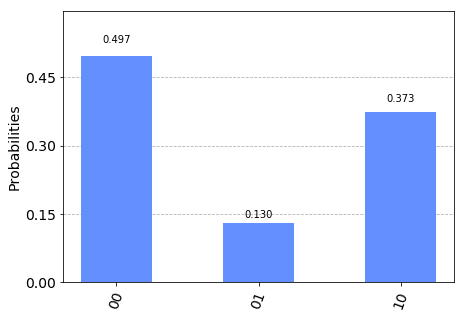

In [104]:
result_noise = execute(circ, backend).result()
counts_noise = result_noise.get_counts(circ)
plot_histogram(counts_noise)

Status @ 0 seconds
JobStatus.INITIALIZING
Status @ 30 seconds
JobStatus.QUEUED
Status @ 60 seconds
JobStatus.QUEUED
Status @ 90 seconds
JobStatus.QUEUED
Status @ 120 seconds
JobStatus.QUEUED
Status @ 150 seconds
JobStatus.QUEUED
Status @ 180 seconds
JobStatus.QUEUED
Status @ 210 seconds
JobStatus.QUEUED
Status @ 240 seconds
JobStatus.QUEUED
Status @ 270 seconds
JobStatus.QUEUED
Status @ 300 seconds
JobStatus.QUEUED
Status @ 330 seconds
JobStatus.QUEUED
Status @ 360 seconds
JobStatus.QUEUED
Status @ 390 seconds
JobStatus.QUEUED
Status @ 420 seconds
JobStatus.QUEUED
Status @ 450 seconds
JobStatus.QUEUED
Status @ 480 seconds
JobStatus.QUEUED
Status @ 510 seconds
JobStatus.QUEUED
Status @ 540 seconds
JobStatus.QUEUED
Status @ 570 seconds
JobStatus.QUEUED
Status @ 600 seconds
JobStatus.QUEUED
Status @ 630 seconds
JobStatus.RUNNING
Status @ 660 seconds
JobStatus.RUNNING
Status @ 690 seconds
JobStatus.RUNNING
JobStatus.DONE


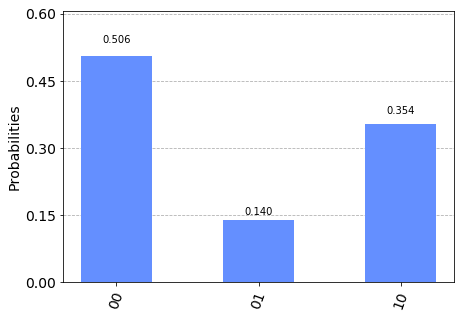

In [108]:
job = execute(circ, device_backend, shots=1024)
lapse = 0
interval = 30
while job.status() != JobStatus.DONE:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    time.sleep(interval)
    lapse += 1
print(job.status())
result_device = job_device.result()
counts_device = result_noise.get_counts(circ)
plot_histogram(counts_device)

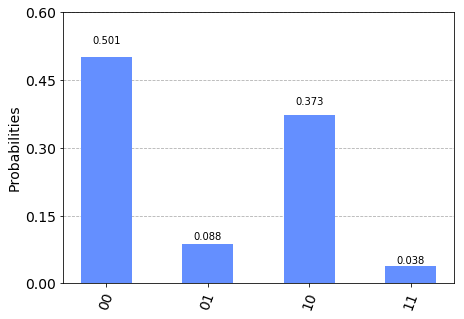

In [112]:
result_device = job.result()
counts_device = result_device.get_counts(circ)
plot_histogram(counts_device)

# Noise Mitigation

In [11]:
def example_circ(circ):
    circ.h(0)
    circ = trotter_electric(circ, [0, 1], 1.0, 1.0, unitary_sim = True, further_opt = False)
    return circ

# Compute the matrix $S$

The matrix $S$ is equivalent to the expectation values of measurements of the exact output state $\Gamma_U(\rho)=U\rho U^\dagger$ in the Pauli basis.
\begin{align}
S_{i, k} = \langle\langle{k|R_{\Gamma_U}|\rho_i}\rangle\rangle = \langle\langle{k|U\rho_iU^\dagger}\rangle\rangle = Tr(P_k U\rho_iU^\dagger)
\end{align}

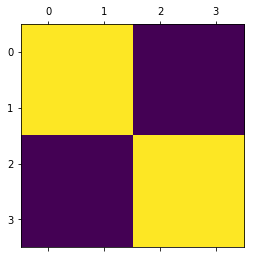

In [12]:
backend = Aer.get_backend('unitary_simulator')

cr = ClassicalRegister(2, 'cr')
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr, cr)
circ = example_circ(circ)
job = execute(circ, backend)
U = job.result().get_unitary()
plt.matshow(np.abs(U))
plt.show()


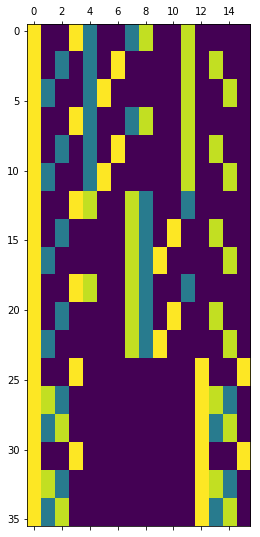

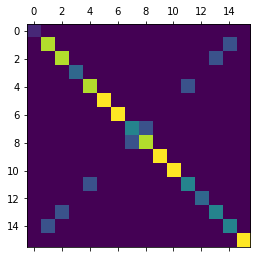

In [13]:
# Compute the 1-qubit states that are bases of X, Y, Z
ref1 = [
    np.array([1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex),
    np.array([1/np.sqrt(2), -1/np.sqrt(2)], dtype=complex),
    np.array([1/np.sqrt(2), 1j/np.sqrt(2)], dtype=complex),
    np.array([1/np.sqrt(2), -1j/np.sqrt(2)], dtype=complex),
    np.array([1, 0], dtype=complex),
    np.array([0, 1], dtype=complex)
]


# Compute the 2-qubit reference states
ref = []
for itr, (i, j) in enumerate([p for p in itertools.product(list(range(6)), repeat=2)]):
    state = np.kron(ref1[i], ref1[j])
    ref.append(np.outer(np.conjugate(state), state))

S = np.zeros((36, 16), complex)
for k, (k1, k2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    for i in range(36):
        S[i, k] = np.trace(matmul([np.kron(sig[k1], sig[k2]), U, ref[i], np.conjugate(U).T]))/np.sqrt(4)
plt.matshow(np.abs(S))
plt.show()
S_H = np.conjugate(S).T
SS = np.matmul(S_H, S)
SS_inv = np.linalg.inv(SS)
plt.matshow(np.abs(SS_inv))
plt.show()

## Compute the PTM of $\epsilon$
\begin{equation}
\langle\langle{k|R_\epsilon|l}\rangle\rangle = ((S^\dagger S)^{-1}S^\dagger P)^T_{k, l}
\end{equation}

In [23]:
def expectation(counts, shots):
    return counts.get('00', 0)/shots*(1)+counts.get('11', 0)/shots*(1) \
                    +counts.get('01', 0)/shots*(-1)+counts.get('10', 0)/shots*(-1)
noise_model = NoiseModel.from_backend(device_backend)
shots = 1024
backend = Aer.get_backend('qasm_simulator')
P_S = np.zeros((36, 16))
for i, (i1, i2) in enumerate([p for p in itertools.product(list(range(6)), repeat=2)]): 
    # the input state rho_i = |i1>|i2> where |i1>, |i2> \in {|0>, |1>, |+>, |->, |R>, |L>}
    for j, (j1, j2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
        if j == 0:
            P_S[i, j] = 1.0
            continue
        else:
            cr = ClassicalRegister(2, 'cr')
            qr = QuantumRegister(2, 'qr')
            circ = QuantumCircuit(qr, cr)
            change_basis_input(circ, i1, 1)
            change_basis_input(circ, i2, 0)
            circ = example_circ(circ)
            if j1 == 0:
                # Measure only the 0-th  with the basis specified with j
                change_basis_measurement(circ, j2, 0)
                circ.measure(qr[0], cr[0])
            else:
                if j2 == 0:
                    # Measure only the 1-th qubit with the basis specified with i
                    change_basis_measurement(circ, j1, 1)
                    circ.measure(qr[1], cr[1])
                else:
                    # Measure both of the two qubits with the bases specified with i and j
                    change_basis_measurement(circ, j1, 1)
                    change_basis_measurement(circ, j2, 0)
                    circ.measure(qr, cr)
            job = execute(circ, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates,
                       shots = shots)
            P_S[i, j] =expectation(job.result().get_counts(circ), shots)
    
P_S /= np.sqrt(4)
print(P_S)

[[ 0.5        -0.01367188 -0.00488281  0.45703125 -0.15820312 -0.01953125
  -0.00390625 -0.12792969  0.39648438  0.03515625 -0.0078125   0.3828125
  -0.0078125  -0.01074219  0.00488281  0.03027344]
 [ 0.5         0.00585938 -0.00488281 -0.453125   -0.16210938 -0.00292969
  -0.04492188  0.13867188 -0.36523438  0.00488281  0.01171875  0.34375
   0.02148438  0.00195312  0.00878906 -0.00585938]
 [ 0.5         0.02050781 -0.18359375  0.         -0.14453125 -0.00292969
   0.37402344 -0.00976562  0.00390625 -0.00683594 -0.01367188  0.3515625
  -0.00390625 -0.36816406 -0.01269531  0.02734375]
 [ 0.5        -0.00097656  0.20898438  0.00585938 -0.13964844  0.00195312
  -0.37402344  0.00390625  0.01269531 -0.02246094 -0.02148438  0.37109375
   0.02832031  0.35644531  0.00195312 -0.00585938]
 [ 0.5        -0.15234375  0.01660156  0.02441406 -0.1484375   0.3984375
   0.01855469  0.01660156  0.04882812  0.00585938 -0.01367188  0.36425781
   0.04003906 -0.01367188  0.37011719 -0.0078125 ]
 [ 0.5     

(1.0000000000000002+1.0793834961633474e-17j)


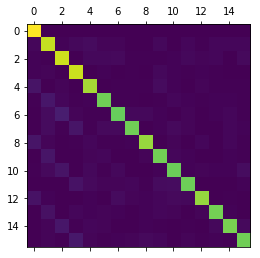

In [24]:
ptm_eps = matmul([SS_inv, S_H, P_S]).T
print(ptm_eps[0, 0])
plt.matshow(np.abs(ptm_eps))
plt.show()

## The inner product between Paulis and reference states 
\begin{align}
\langle\langle l|\rho_i \rangle\rangle = \frac{1}{\sqrt{d}}Tr(P_l \rho_i)
\end{align}
For the reference state $\rho_i$, which must be some physical states of at least 16, we choose $\{|0\rangle, |1\rangle, |+\rangle, |-\rangle, |R\rangle, |L\rangle\}^{\otimes 2}$.  

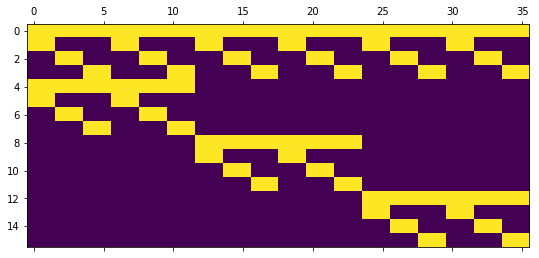

In [25]:
inn_mrho = np.zeros((16, 36), dtype=complex)
for l, (l1, l2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    for i in range(36):
        inn_mrho[l, i] = np.trace(np.matmul(np.kron(sig[l1], sig[l2]), ref[i]))/np.sqrt(4)
plt.matshow(np.abs(inn_mrho))
plt.show()

## Compute the matrix $T$
The matrix $T$ is given as 
\begin{align}
T_{i, k} = \sum_l \langle\langle{k|R_\epsilon|l}\rangle\rangle\langle\langle{l|\rho_i}\rangle\rangle
\end{align}

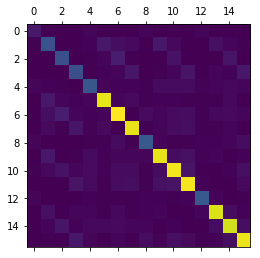

In [26]:
T = matmul([ptm_eps, inn_mrho]).T
T_H = np.conjugate(T).T
TT = np.matmul(T_H, T)
TT_inv = np.linalg.inv(TT)#+1e-12*np.eye(16))
plt.matshow(np.abs(TT_inv))
plt.show()

## Compute the PTM of $\epsilon^{-1}$
\begin{equation}
\langle\langle{j|R_{\epsilon^{-1}}|k}\rangle\rangle = ((T^\dagger T)^{-1}T^\dagger P)^T_{j, k}
\end{equation}

In [27]:
ptm_eps_inv = matmul([TT_inv, T_H, inn_mrho.T]).T
print(ptm_eps_inv)

[[ 1.00000000e+00-1.04559951e-17j  4.16333634e-17-1.75600116e-17j
   8.76035355e-17-2.93566434e-19j  0.00000000e+00+2.00207621e-18j
   7.45931095e-17+1.16536859e-18j -9.54097912e-17+2.41943651e-20j
  -2.53269627e-16+7.08890315e-19j -9.36750677e-17+5.37698185e-19j
  -9.54097912e-17-1.16379674e-18j  7.02563008e-17-1.97641426e-19j
   1.09504419e-16+7.48252959e-20j  2.40259201e-16+9.55520523e-19j
  -6.93889390e-17+3.73619936e-19j  9.62771529e-17-7.96854172e-19j
  -1.77809156e-17+3.97626521e-18j -2.77555756e-16-3.60757075e-17j]
 [-1.76723566e-02-5.45784787e-18j  1.09738409e+00-9.56254444e-18j
  -9.80338958e-03-8.27800197e-19j  2.35363307e-02+1.98230628e-19j
  -3.99526837e-02+7.47115711e-19j -1.59733380e-02+2.02595488e-19j
  -1.86645812e-02+5.37775064e-19j  3.07607660e-03+5.42539082e-21j
   1.35411401e-03+7.63451509e-20j -2.71675954e-02+6.00019624e-19j
   6.08149288e-04-1.20349229e-18j -2.72249423e-02+3.20005326e-19j
  -7.98049231e-03+1.62416704e-19j  2.22020202e-02-9.45437700e-20j
  -2.4234

  -9.69350093e-03-1.73117097e-17j  1.27831055e+00-3.67938232e-17j]]


## Compute the matrix $\Sigma = Tr[P_k P_i P_l P_j]$ to recover the process matrix from the PTM
One may recover the process matrix by
\begin{align}
\vec{\chi} = \Sigma^{-1}\vec{m}
\end{align}
where $\vec{\chi}_{i+j(d-1)} = \chi_{ij}$ and $\vec{m}_{k+l(d-1)} = \langle\langle k|R_{\epsilon^{-1}}|l \rangle\rangle$. 

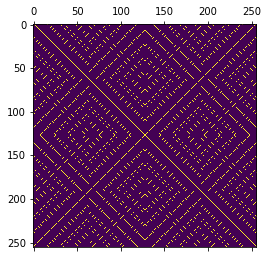

In [28]:
SigTensor1 = np.zeros([4, 4, 4, 4], dtype=complex)
for i in range(4):
    for j in range(4):
        for k in range(4):
            for l in range(4):
                SigTensor1[k, l, i, j] = np.trace(matmul([sig[k], sig[i], sig[l], sig[j]]))/2
SigMat = np.reshape(tensor_prod([SigTensor1 for i in range(2)]), [4**(2*2), 4**(2*2)])
SigMat_H = np.conjugate(SigMat).T 

plt.matshow(np.abs(SigMat))
plt.show()

(0.9999999999999997-1.0455995141420361e-17j)
[ 1.20506586e+00-9.46404132e-18j -2.54917020e-02+1.48875714e-18j
 -2.46919710e-02+9.06053961e-19j -2.30632373e-02-3.16589194e-18j
 -4.68993147e-02-7.01834584e-19j -1.02593705e-03-3.91356320e-18j
 -1.09750093e-03-7.50078224e-20j -5.50281256e-03+3.20692791e-18j
 -4.38209036e-02-2.95582750e-19j  2.88313482e-03-4.22715638e-18j
  1.38399812e-04+4.64867753e-20j  7.96410159e-04+3.28140641e-18j
 -4.94352780e-02+9.20968042e-21j  7.41618554e-03+7.09494161e-18j
 -9.61164688e-04-1.81175567e-18j  5.68983042e-03-2.83494499e-18j]


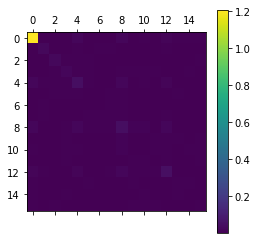

In [29]:
ptm_eps_inv_vec = np.reshape(ptm_eps_inv, [-1, 1])
chi_eps_inv_vec = np.dot(np.linalg.inv(SigMat), ptm_eps_inv_vec)
chi_eps_inv = np.reshape(chi_eps_inv_vec, [16, 16])
print(np.trace(chi_eps_inv))
print(np.diagonal(chi_eps_inv))
plt.matshow(np.abs(chi_eps_inv))
plt.colorbar()
plt.show()

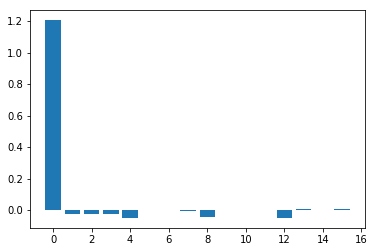

In [30]:
plt.bar(range(16), np.real(np.diagonal(chi_eps_inv)))
plt.show()

## Check if $\chi_{\epsilon^{-1}}$ is correct

In [32]:
backend = Aer.get_backend('statevector_simulator')
cr = ClassicalRegister(2, 'cr')
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr, cr)
circ = example_circ(circ)
job = execute(circ, backend)
state = job.result().get_statevector(circ)
exact_rho = DensityMatrix(state).data
print(exact_rho)

[[ 0.5       +0.j         -0.20807342-0.45464871j  0.        -0.j
   0.        -0.j        ]
 [-0.20807342+0.45464871j  0.5       +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]]


## Tomography the noisy output state

In [33]:
u = np.zeros(4**2)
u[0] = 1.0
shots = 1024

backend = Aer.get_backend('qasm_simulator')
for itr, (i, j) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    # Due to the indexing convension of qiskit, i corresponds to 1-th qubit and j corresponds to 0-th qubit
    if i == 0 and j == 0:
        continue
    else:
        cr = ClassicalRegister(2, 'cr')
        qr = QuantumRegister(2, 'qr')
        circ = QuantumCircuit(qr, cr)
        circ = example_circ(circ)
        if i == 0:
            # Measure only the 0-th qubit with the basis specified with j
            change_basis_measurement(circ, j, 0)
            circ.measure(qr[0], cr[0])
        else:
            if j == 0:
                # Measure only the 1-th qubit with the basis specified with i
                change_basis_measurement(circ, i, 1)
                circ.measure(qr[1], cr[1])
            else:
                # Measure both of the two qubits with the bases specified with i and j
                change_basis_measurement(circ, i, 1)
                change_basis_measurement(circ, j, 0)
                circ.measure(qr, cr)
        job = execute(circ, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates,
                       shots = shots)
        u[itr] =job.result().get_counts(circ).get('00', 0)/shots*(1)+job.result().get_counts(circ).get('11', 0)/shots*(1) \
                        +job.result().get_counts(circ).get('01', 0)/shots*(-1)+job.result().get_counts(circ).get('10', 0)/shots*(-1)
noisy_rho = sum([np.kron(sig[i], sig[j])*u[itr] for itr, (i, j) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)])])/2**2
print(noisy_rho)
print("MAE = ", np.mean(np.abs(noisy_rho - exact_rho)))

[[ 0.45361328+0.j         -0.17578125-0.39550781j  0.02880859-0.02734375j
  -0.03027344-0.00537109j]
 [-0.17578125+0.39550781j  0.50048828+0.j         -0.00195312+0.01123047j
   0.00244141-0.00878906j]
 [ 0.02880859+0.02734375j -0.00195312-0.01123047j  0.01025391+0.j
  -0.01074219-0.02246094j]
 [-0.03027344+0.00537109j  0.00244141+0.00878906j -0.01074219+0.02246094j
   0.03564453+0.j        ]]
MAE =  0.02870666277342436


[[ 0.47223979-2.03950320e-17j -0.20910935-4.41165073e-01j
   0.01710801-2.11910529e-02j -0.02272223+1.21116255e-02j]
 [-0.20910935+4.41165073e-01j  0.53312756+1.12392036e-17j
  -0.00118469-1.85877163e-02j -0.0130382 +5.54521214e-03j]
 [ 0.01710801+2.11910529e-02j -0.00118469+1.85877163e-02j
  -0.01776128+4.38905459e-18j -0.02725201-7.93756705e-03j]
 [-0.02272223-1.21116255e-02j -0.0130382 -5.54521214e-03j
  -0.02725201+7.93756705e-03j  0.01239392-2.24319661e-18j]]


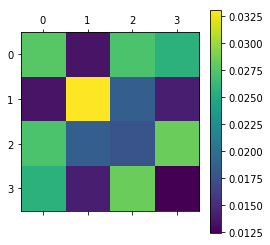

MAE =  0.02165084581752095


In [34]:
mitigated_rho = np.zeros((4, 4), dtype=complex)
for i, (i1, i2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    for j, (j1, j2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
        mitigated_rho += chi_eps_inv[i, j]*np.matmul(np.matmul(np.kron(sig[i1], sig[i2]), noisy_rho), np.kron(sig[j1], sig[j2]))
        
print(mitigated_rho)
plt.matshow(np.abs(mitigated_rho-exact_rho))
plt.colorbar()
plt.show()
print("MAE = ", np.mean(np.abs(mitigated_rho - exact_rho)))

[[ 0.49349641-3.40303439e-18j -0.20663039-4.58940027e-01j
   0.03489108-3.33203870e-02j -0.03875596-7.04607065e-03j]
 [-0.20663039+4.58940027e-01j  0.54645625-4.14058503e-18j
  -0.00232082+1.45081575e-02j  0.00118975-9.44756558e-03j]
 [ 0.03489108+3.33203870e-02j -0.00232082-1.45081575e-02j
  -0.0327244 -1.48265869e-18j  0.00194253+8.95643552e-03j]
 [-0.03875596+7.04607065e-03j  0.00118975+9.44756558e-03j
   0.00194253-8.95643552e-03j -0.00722826-1.42971703e-18j]]


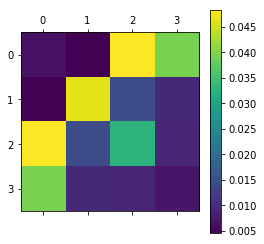

MAE =  0.021499999470801834


In [35]:
mitigated_rho_diag = np.zeros((4, 4), dtype=complex)
for i, (i1, i2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    mitigated_rho_diag += chi_eps_inv[i, i]*np.matmul(np.matmul(np.kron(sig[i1], sig[i2]), noisy_rho), np.kron(sig[i1], sig[i2]))
        
print(mitigated_rho_diag)
plt.matshow(np.abs(mitigated_rho_diag-exact_rho))
plt.colorbar()
plt.show()
print("MAE = ", np.mean(np.abs(mitigated_rho_diag - exact_rho)))

[[ 0.48770101-4.53658036e-18j -0.20607716-4.64461253e-01j
   0.03526479-3.33152380e-02j -0.03866869-6.83632739e-03j]
 [-0.20607716+4.64461253e-01j  0.54083902-5.26575860e-18j
  -0.00237784+1.43354078e-02j  0.0015532 -9.47803122e-03j]
 [ 0.03526479+3.33152380e-02j -0.00237784-1.43354078e-02j
  -0.03132743-4.96491547e-19j  0.00329375+9.38802416e-03j]
 [-0.03866869+6.83632739e-03j  0.0015532 +9.47803122e-03j
   0.00329375-9.38802416e-03j -0.00554915-9.24499295e-19j]]


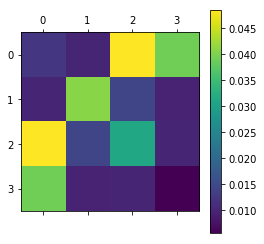

MAE =  0.02211087101509859


In [36]:
mitigated_rho_diag = np.zeros((4, 4), dtype=complex)
for i, (i1, i2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    if i in [ 0,  1,  2,  3,  4,  8, 12]:
        mitigated_rho_diag += chi_eps_inv[i, i]*np.matmul(np.matmul(np.kron(sig[i1], sig[i2]), noisy_rho), np.kron(sig[i1], sig[i2]))
        
print(mitigated_rho_diag)
plt.matshow(np.abs(mitigated_rho_diag-exact_rho))
plt.colorbar()
plt.show()
print("MAE = ", np.mean(np.abs(mitigated_rho_diag - exact_rho)))

# Quasi-probability

## Ideal

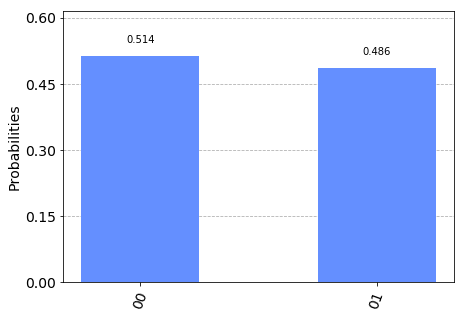

In [37]:
cr = ClassicalRegister(2, 'cr')
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
circ.measure(qr, cr)
job = execute(circ, backend, 
                       shots = shots)
counts = job.result().get_counts(circ)
plot_histogram(counts)

## No mitigation

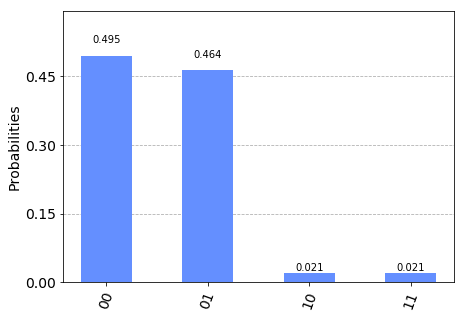

In [38]:
cr = ClassicalRegister(2, 'cr')
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
circ.measure(qr, cr)
job = execute(circ, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates,
                       shots = shots)
counts = job.result().get_counts(circ)
plot_histogram(counts)

## With mitigation

1.2050658610063858
-0.025491701997027952
-0.024691970952128495
-0.02306323731268621
-0.046899314701690675
-0.04382090361643787
-0.049435277963781055


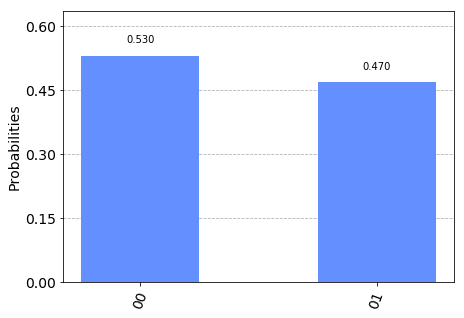

In [39]:
def dec_to_binary_str(dec, n_dig):
    s = bin(dec).replace("0b", "")
    return '0'*(n_dig - len(s)) +s 
dist = {dec_to_binary_str(i, 2): 0. for i in range(4)}

index = np.where(np.abs(np.real(np.diagonal(chi_eps_inv))) > 1e-2)[0]
backend = Aer.get_backend('qasm_simulator')
for i in index:
    print(np.real(np.diagonal(chi_eps_inv))[i])
    i1 = i//4
    i2 = i%4
    cr = ClassicalRegister(2, 'cr')
    qr = QuantumRegister(2, 'qr')
    circ = QuantumCircuit(qr, cr)
    example_circ(circ)
    if i1 == 1:
        circ.x(1)
    elif i1 == 2:
        circ.y(1)
    elif i1 == 3:
        circ.z(1)
    if i2 == 1:
        circ.x(0)
    elif i2 == 2:
        circ.y(0)
    elif i2 == 3:
        circ.z(0)
    
    circ.measure(qr, cr)
    job = execute(circ, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates,
                       shots = shots)
    counts = job.result().get_counts(circ)
    for key in counts.keys():
        dist[key] += np.real(np.diagonal(chi_eps_inv))[i]*counts[key]
        
plot_histogram(dist)